This notebook uses zipline to backtest the sector rotation strategy. This should handle the dividends and cash positions in a better fashion. 
We use a set of risk-off assets to invest in if the risk is above it's 1-standard deviation


In [1]:
import time
import warnings

import pandas as pd
import numpy as np
import quantstats as qs
import yfinance as yf
import matplotlib.pyplot as plt

from zipline import run_algorithm
from zipline.api import (
    calendars,
    date_rules,
    time_rules,
    order_target_percent,
    schedule_function,
    symbol
)
from zipline.finance.commission import PerTrade


C:\Users\vwste\AppData\Local\Temp\ipykernel_10128\3220805958.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
class EWMAC(object):

    def __init__(self, max_val=20, min_val=-20, vol_lookback=25):
        self.max_val = max_val
        self.min_val = min_val
        self.vol_lookback = vol_lookback

    def ewmac_forecast_scalar(self, Lfast, Lslow):

        fsdict = dict(l2_8=10.6, l4_16=7.5, l8_32=5.3, l16_64=3.75, l32_128=2.65, l64_256=1.87)

        lkey = "l%d_%d" % (Lfast, Lslow)

        if lkey in fsdict:
            return fsdict[lkey]
        else:
            print("Warning: No scalar defined for Lfast=%d, Lslow=%d, using default of 1.0" % (Lfast, Lslow))
            return 1.0

    def __call__(self, price, Lfast=16):

        Lslow = 4 * Lfast

        fast_ewma = price.ewm(span=Lfast).mean()
        slow_ewma = price.ewm(span=Lslow).mean()
        raw_ewmac = fast_ewma - slow_ewma

        stdev_returns = price.diff().ewm(span=self.vol_lookback).std()
        vol_adj_ewmac = raw_ewmac / stdev_returns

        f_scalar = self.ewmac_forecast_scalar(Lfast, Lslow)

        forecast = vol_adj_ewmac * f_scalar

        return (np.maximum(np.minimum(forecast, self.max_val), self.min_val)) / self.max_val

In [4]:
def calc_ewma(full_df, lengths=None):

    if lengths is None:
        lengths = [16, 32, 64]

    for Lfast in lengths:
        ewmacs = EWMAC()(full_df, Lfast)
        if not 'avg_ewmacs' in locals():
            avg_ewmacs = ewmacs
        else:
            avg_ewmacs += ewmacs
    avg_ewmacs /= len(lengths)
    return avg_ewmacs

In [5]:
backtest_start = '2004-12-31'
backtest_end = '2023-12-31'

universe = {"VNQ": 'Vanguard Real Estate Index Fund',  # IUSP
            "XLK": 'Technology',  # XLKS
            "XLE": 'Energy',  # XLES
            "XLV": 'Health Care',  # XLVS
            "XLF": 'Financial',  # XLFS
            "XLI": 'Industrials',  # XLIS
            "XLB": 'Materials',  # XLBS
            "XLY": 'Consumer Discretionary',  # XLYS
            "XLP": 'Consumer Staples',  # XLPS
            "XLU": 'Utilities'}  # XLUS

ro_universe = {'FXF': 'Long CHF',
               'IAU': 'Gold',
               'IEF': 'Treasury Bond',
               'TLT': 'Long Term Bond',
               'FXY': 'JPYUSD'}

ewma_lengths = [16, 32, 64]
min_val = 0
num_assets = 5
day_offset = 1
benchmark_ticker = '^SP500TR'
allow_short = False
max_weight_long = 1/3
max_weight_short = 0.05


In [6]:
from scipy.stats import t
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import Bounds

class RiskMeasures:
    
    def __init__(self, confidence_level):
        self._confidence_level = confidence_level
    
    def value_at_risk(self, returns):
        return returns.quantile(self._confidence_level)
        
    def expected_shortfall(self, returns):
        returns = returns[returns!=0]
        var = self.value_at_risk(returns)
        return abs(returns[returns.lt(var)].mean())

In [7]:
def fun_rolling_cvar(rets):
    rm = RiskMeasures(confidence_level=0.05)
    risk_strategy = rm.expected_shortfall(returns=rets)
    return risk_strategy

In [8]:
def get_data(ticker):
    data = ticker.history(period='max')
    return data['Close'].rename(ticker.ticker)

In [9]:
bm_price = get_data(yf.Ticker('IVV'))
bm_price.index = bm_price.index.tz_localize(None)

c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [10]:
def get_risk(bm_price, settings):

    risk_zscore = settings['risk_zscore'] #True
    z_lookback = settings['z_lookback'] #252*3
    avg_lookback = settings['avg_lookback'] #250
    z_upper_limit = settings['upper_limit'] #1.25
    z_lower_limit = settings['lower_limit'] #0
    avg_std = settings['avg_std'] #1
    
    rolling_cvar = np.log(bm_price).diff().rolling(window=20).apply(fun_rolling_cvar)
    df_risk = pd.DataFrame(rolling_cvar.ewm(span=3).mean())
    
    df_risk.columns = ['Risk']

    if risk_zscore:
        df_risk['zscore'] = ((df_risk['Risk'] - df_risk['Risk'].rolling(window=z_lookback, min_periods=100).mean())/df_risk['Risk'].rolling(window=z_lookback, min_periods=100).std())
        df_risk['upper_limit'] = z_upper_limit
        df_risk['lower_limit'] = z_lower_limit
        df_risk['upper_breach'] = np.where(df_risk['zscore'] > df_risk['upper_limit'], 1, 0)
        df_risk['lower_breach'] = np.where(df_risk['zscore'] < df_risk['lower_limit'], 1, 0)
    else:
        df_risk['upper_limit'] = df_risk['Risk'].rolling(window=avg_lookback, min_periods=1).mean() + avg_std * df_risk['Risk'].rolling(window=avg_lookback, min_periods=1).std()
        df_risk['upper_breach'] = np.where(df_risk['Risk'] > df_risk['upper_limit'], 1, 0)
        df_risk['lower_breach'] = 0 

    df_risk['upper_action'] = df_risk['upper_breach'].diff()
    df_risk['lower_action'] = df_risk['lower_breach'].diff()
    df_risk = df_risk[backtest_start:] 
    
    return df_risk

In [11]:
risk_zscore = True
df_risk = get_risk(bm_price, settings={'risk_zscore': risk_zscore, 'z_lookback': 252*3, 'avg_lookback': 250, 'upper_limit': 1., 'lower_limit': 0, 'avg_std': 1})

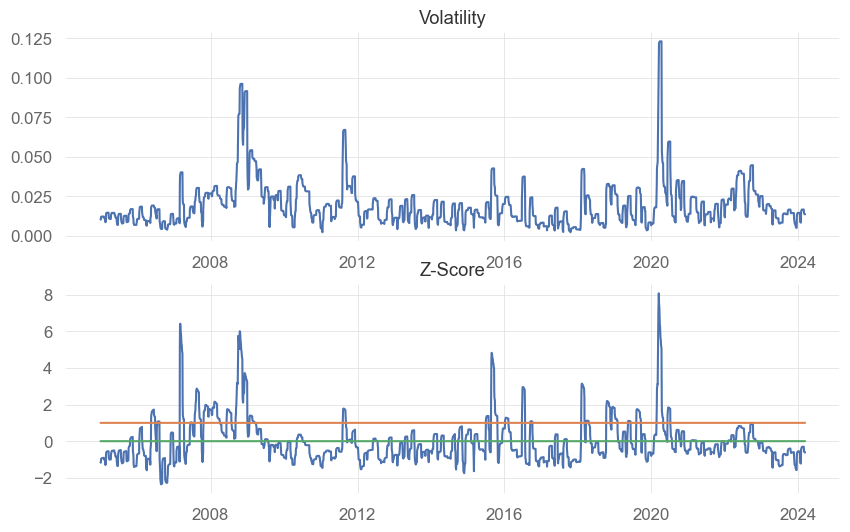

In [12]:
fig, ax = plt.subplots(nrows=2)
ax[0].set_title('Volatility')
ax[0].plot(df_risk['Risk'])

ax[1].set_title('Z-Score')
ax[1].plot(df_risk['zscore'])
ax[1].plot(df_risk['upper_limit'])
ax[1].plot(df_risk['lower_limit']);


In [13]:
def initialize(context):

    context.universe = universe
    context.ro_universe = ro_universe
    context.ewma_lengths = ewma_lengths
    context.min_val = min_val
    context.num_assets = num_assets
    context.allow_short = allow_short
    context.max_weight_long = max_weight_long
    context.max_weight_short = max_weight_short
    context.set_commission(PerTrade(cost=1.0))
    
    # Schedule the daily risk check function
    schedule_function(
        func=check_risk_and_rebalance,
        date_rule=date_rules.every_day(),
        time_rule=time_rules.market_close(),
        calendar=calendars.US_EQUITIES,
    )
    
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_end(days_offset=day_offset),
        time_rule=time_rules.market_close(),
        calendar=calendars.US_EQUITIES,
    )
    
def get_sorted_momentum(context, data, allow_short, universe='normal'):
    
    current_date = context.get_datetime().normalize().tz_localize(None)
    
    if universe == 'normal':
        zipline_universe = [symbol(tkr) for tkr in list(context.universe.keys())]
    else:
        zipline_universe = [symbol(tkr) for tkr in list(context.ro_universe.keys())]
    hist = data.history(zipline_universe, "close", 252, "1d")
        
    ewma = calc_ewma(hist, context.ewma_lengths)
    sorted_values = ewma.loc[current_date].sort_values(ascending=False)
    
    if not len(sorted_values[sorted_values > context.min_val]):
        #print(f'{current_date}: No positive: all in cash')
        longs = []
    else:
        longs = list(sorted_values[sorted_values > min_val].index[:num_assets])
        #print(f'Long: {current_date}: {longs}')
    
    shorts = []
    if allow_short:
        if not len(sorted_values[sorted_values < context.min_val]):
            print(f'Short: {current_date}: No negative')
            shorts = []
        else:
            shorts = list(sorted_values[sorted_values < min_val].index[-3:])
            print(f'{current_date}: {len(shorts)}')
    
    return sorted_values, longs, shorts


def check_risk_and_rebalance(context, data):
    # This function will check the risk daily and decide whether to move to cash
    current_date = context.get_datetime().normalize().tz_localize(None)
    try:
        current_risk = df_risk.loc[current_date.strftime('%Y-%m-%d')]['zscore']
        upper_limit = df_risk.loc[current_date.strftime('%Y-%m-%d')]['upper_limit']
    except KeyError:
        # If current_date is not in df_risk, do nothing
        return

    if current_risk > upper_limit:
        # If current risk is above the upper limit, move to RO       
        sorted_values, longs, _ = get_sorted_momentum(context, data, allow_short=False, universe='risk')        
        
        for stock in context.portfolio.positions:
            #print(current_date, stock, stock in longs, stock in context.universe)
            if (not stock in longs) or (stock in context.universe):
                order_target_percent(stock, 0)
        
        for stock in longs:
            if data.can_trade(stock) and not stock in context.portfolio.positions:
                weight = min(context.max_weight_long, 1/len(longs))
                order_target_percent(stock, weight)
                #To Do: this should be rebalanced at the end of the month?
                
        #print(f"{current_date}: Risk above upper limit. {context.portfolio.positions}")
        
    else:
        for stock in context.portfolio.positions:
            if stock in context.ro_universe:
                order_target_percent(stock, 0)
        
        # Check if we have to reinvest        
        in_pos = [stock for stock in context.portfolio.positions]
        if len(in_pos) == 0:
            print(f'{current_date}: No positions, rebalancing')
            rebalance(context, data)


def rebalance_with_buffer(context, data, longs, optimal_weight, buffer):
    total_portfolio_value = context.portfolio.portfolio_value
    
    for asset in longs:
        if data.can_trade(asset):
            if asset not in context.portfolio.positions:
                # If the asset is not in the portfolio, order to optimal weight
                order_target_percent(asset, optimal_weight)
            else:
                # Calculate the current weight of the asset in the portfolio
                current_position_value = context.portfolio.positions[asset].amount * data.current(asset, 'price')
                current_weight = current_position_value / total_portfolio_value
                
                # Calculate the buffer zone
                lower_bound = optimal_weight * (1 - buffer)
                upper_bound = optimal_weight * (1 + buffer)
                
                # Check if the current weight is outside the buffer zone
                if not (lower_bound <= current_weight <= upper_bound):
                    # Adjust the position to the optimal weight
                    order_target_percent(asset, optimal_weight)
                else:
                    pass
                    #print(f'{asset} in buffer')

def rebalance(context, data):

    current_date = context.get_datetime().normalize().tz_localize(None)
    
    try:
        current_risk = df_risk.loc[current_date.strftime('%Y-%m-%d')]['zscore']
        upper_limit = df_risk.loc[current_date.strftime('%Y-%m-%d')]['upper_limit']
    except KeyError:
        # If current_date is not in df_risk, do nothing
        return

    if current_risk < upper_limit:
    
        #print(f"Rebalancing on {current_date.strftime('%Y-%m-%d')}")
        sorted_values, longs, shorts = get_sorted_momentum(context, data, allow_short = context.allow_short, universe='normal')
        
        if len(longs) == 0: #check if we can invest in risk-off assets
            print(f"No longs, falling back to Risk-off: {current_date.strftime('%Y-%m-%d')}")
            sorted_values, longs, shorts = get_sorted_momentum(context, data, allow_short = False, universe='risk')
            
        if context.allow_short:
            invested_assets = longs + shorts
        else:
            invested_assets = longs
        
        for stock in context.portfolio.positions:
            if stock not in invested_assets:
                order_target_percent(stock, 0)

        """
        for stock in longs:
            if data.can_trade(stock):
                weight = min(context.max_weight_long, 1/len(longs))
                order_target_percent(stock, weight)
        """
        
        rebalance_with_buffer(context, data, longs, 1/len(longs), 0.05)
        
                
        if context.allow_short:
            for stock in shorts:
                if data.can_trade(stock):
                    weight = min(context.max_weight_short, 1/len(shorts))
                    order_target_percent(stock, -weight)
    else:
        #Rebalance risk-off portfolio
        sorted_values, longs, shorts = get_sorted_momentum(context, data, allow_short = context.allow_short, universe='risk')
        
        for stock in context.portfolio.positions:
            if stock not in longs:
                order_target_percent(stock, 0)

        for stock in longs:
            if data.can_trade(stock):
                weight = min(context.max_weight_long, 1/len(longs))
                order_target_percent(stock, weight)
    
def before_trading_start(context, data):
    pass

def analyze(context, perf):
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return 

start_date = pd.Timestamp(backtest_start)
end_date = pd.Timestamp(backtest_end)

start_time = time.time()
perf = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    before_trading_start=before_trading_start,
    analyze=analyze,
    capital_base=100000,
    bundle="tiingo_etf_bundle",
)

Bundle registered successfully.
2004-12-31 00:00:00: No positions, rebalancing


C:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\zipline_extended\src\zipline\finance\ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


No longs, falling back to Risk-off: 2008-07-30
No longs, falling back to Risk-off: 2009-03-30
2015-07-28 00:00:00: No positions, rebalancing
2018-11-23 00:00:00: No positions, rebalancing
Annualized Return: 11.61% Max Drawdown: -21.44%


In [14]:
qs.reports.metrics(perf['portfolio_value'])

c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\quantstats\stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    Strategy
------------------  ----------------------
Start Period        2004-12-31
End Period          2023-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   -
CAGR﹪              7.87%

Sharpe              0.87
Prob. Sharpe Ratio  99.99%
Sortino             1.22
Sortino/√2          0.86
Omega               1.17

Max Drawdown        -21.44%
Longest DD Days     808

Gain/Pain Ratio     0.17
Gain/Pain (1M)      1.1

Payoff Ratio        0.96
Profit Factor       -
Common Sense Ratio  1.16
CPC Index           0.61
Tail Ratio          6.87
Outlier Win Ratio   2.26
Outlier Loss Ratio  -

MTD                 8.50734156876242e+119%
3M                  -
6M                  -
YTD                 -
1Y                  -
3Y (ann.)           8.58%
5Y (ann.)           9.09%
10Y (ann.)          6.57%
All-time (ann.)     7.87%

Avg. Drawdown       -2.1%
Avg. Drawdown Days  24
Recovery Factor     10.56
Ulcer Index         0.06
Serenity Index      4.631111

In [15]:
def fetch_benchmark_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    benchmark = df['Adj Close'].pct_change().fillna(0).add(1).cumprod()
    return benchmark

In [16]:
benchmark_data = fetch_benchmark_data(benchmark_ticker, start_date, end_date)
perf.index = perf.index.tz_localize(None)
aligned_benchmark = benchmark_data.reindex(perf.index, method='ffill')

c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over bot

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-04   2005-01-04
End Period                 2023-12-29   2023-12-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          478.6%       704.46%
CAGR﹪                     6.59%        7.87%

Sharpe                     0.57         0.87
Prob. Sharpe Ratio         99.34%       99.99%
Smart Sharpe               0.56         0.85
Sortino                    0.8          1.22
Smart Sortino              0.79         1.2
Sortino/√2                 0.57         0.86
Smart Sortino/√2           0.56         0.85
Omega                      1.17         1.17

Max Drawdown               -55.25%      -21.44%
Longest DD Days            1634         808
Volatility (ann.)          19.46%       13.78%
R^2                        0.18         0.18
Information Ratio          0.0          0.0
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-06-24,2016-01-08,2017-09-08,808,-21.442523,-20.524361
2,2022-04-21,2022-07-14,2022-11-04,198,-19.135026,-17.840252
3,2011-07-08,2011-10-04,2012-07-26,385,-16.850162,-16.240343
4,2010-04-30,2010-07-06,2010-11-03,188,-16.427894,-14.401037
5,2008-12-19,2009-07-08,2009-09-15,270,-16.332825,-16.253722


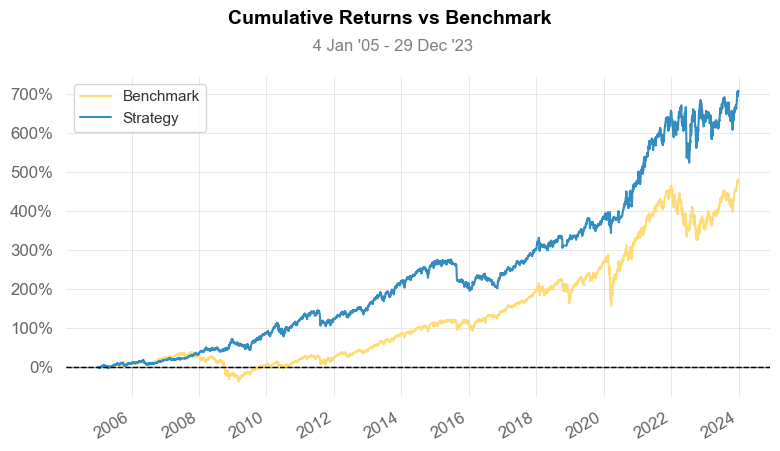

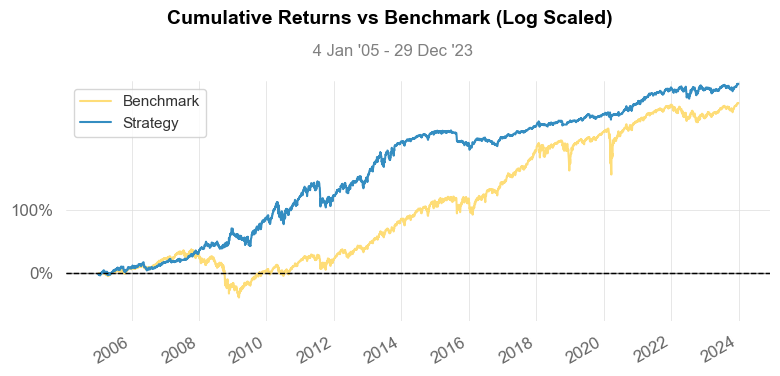

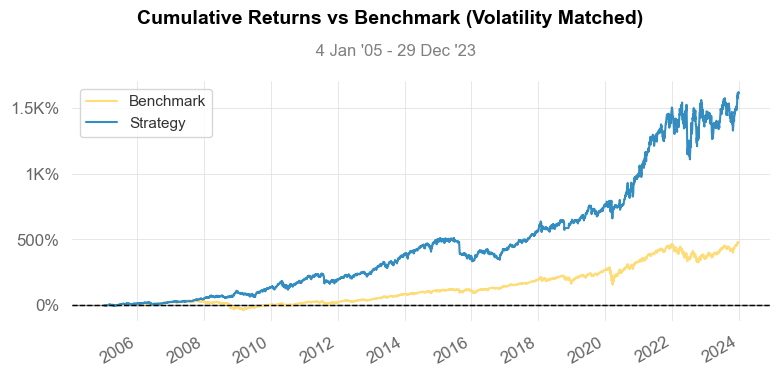

c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\quantstats\_plotting\wrappers.py:554: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  _utils._prepare_benchmark(benchmark, returns.index)
c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


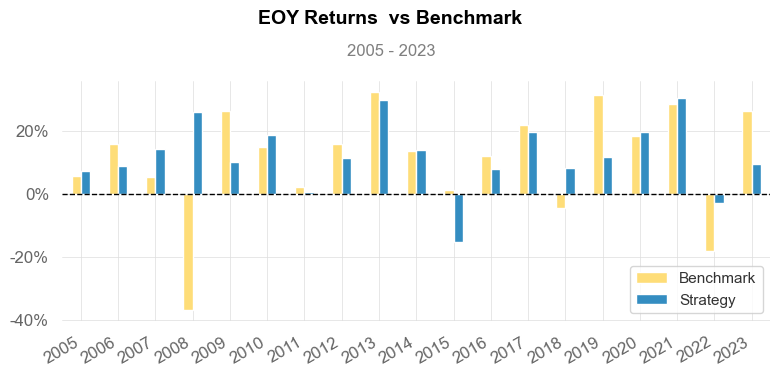

c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\quantstats\_plotting\core.py:432: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  benchmark.fillna(0)
c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


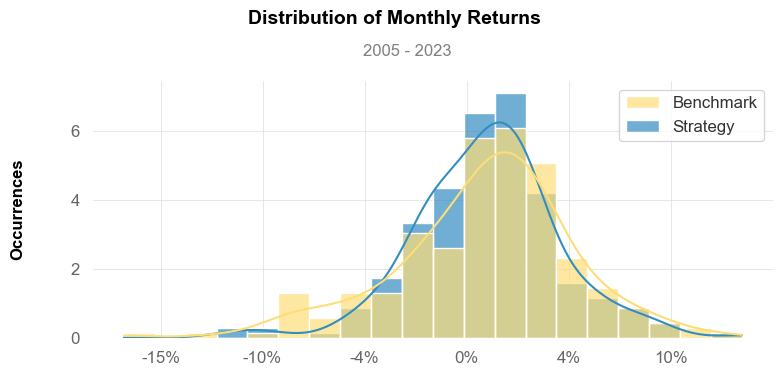

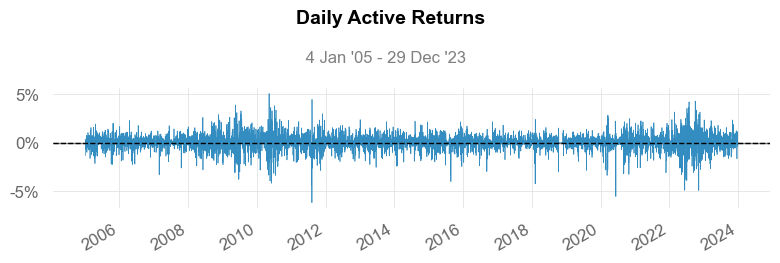

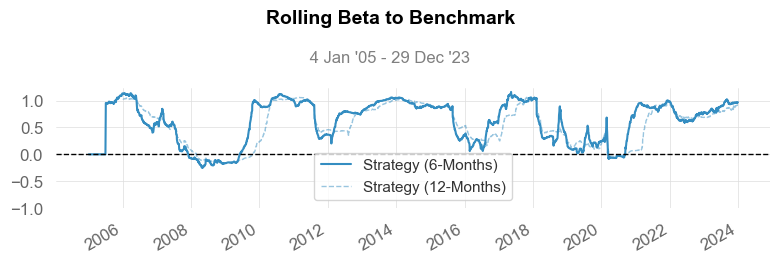

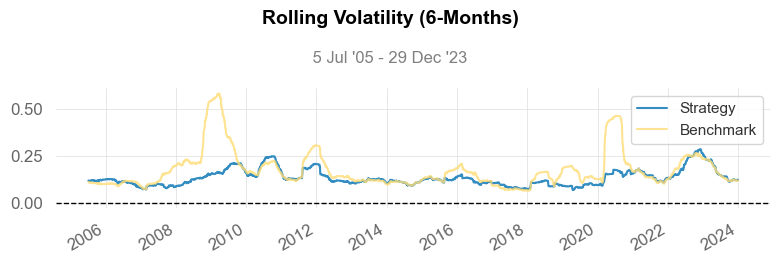

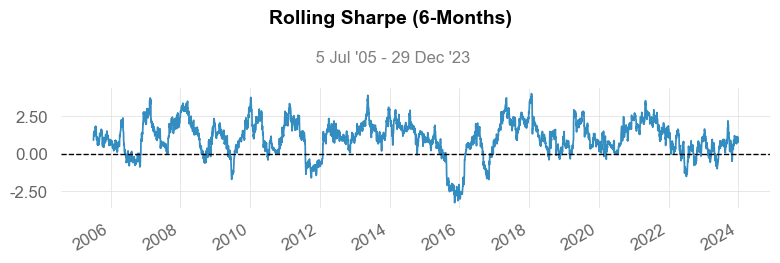

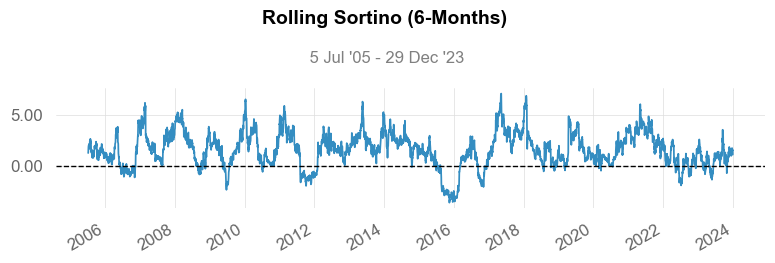

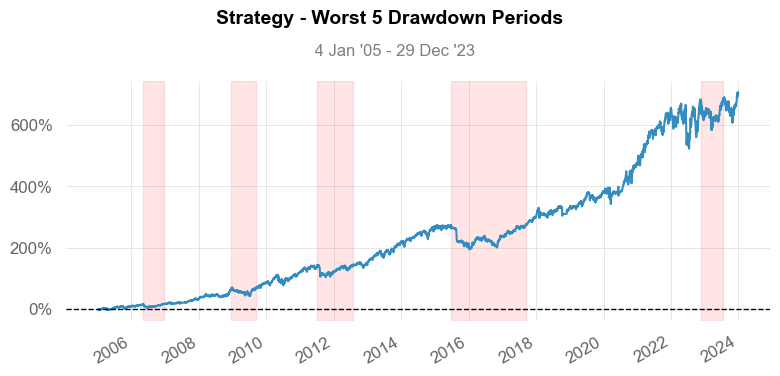

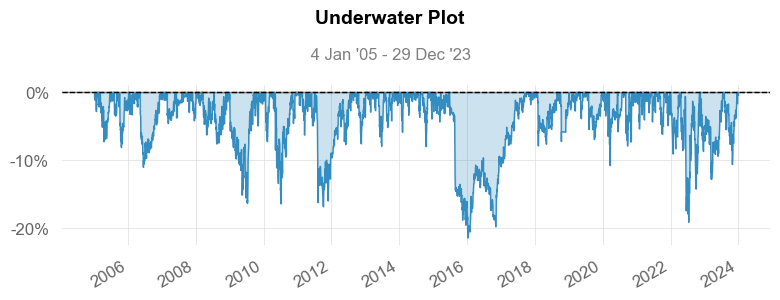

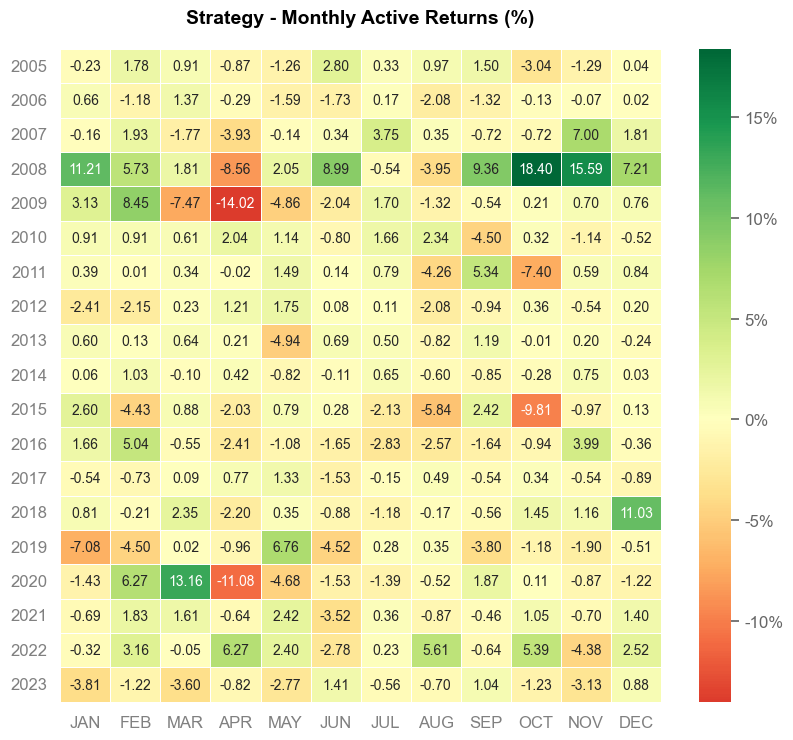

c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\vwste\OneDrive\Documents\Python Scripts\factorflow\venv_zip\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\vwste\OneDrive\Documents\Python Sc

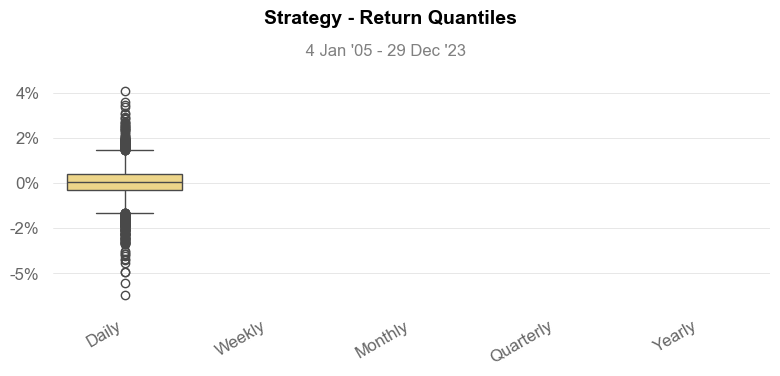

In [17]:
start_year = '2005'
qs.reports.full(returns=perf['portfolio_value'][start_year:],
                benchmark=aligned_benchmark[start_year:],
                output='report.html',
                title='Sector Rotation Strategy')